In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# input dataset
input_file = "/content/drive/MyDrive/all_combined_training.csv"
validation_file = "/content/drive/MyDrive/all_combined_validation.csv"
model_root= "/content/drive/MyDrive/Colab Notebooks/models/"
# TODO: XGBoost parameters

In [ ]:
# %%capture suppresses the large output
%%capture
!pip install matplotlib>=3.1.3
!pip install statsmodels>=0.12.2
!pip install sktime
!pip install pmdarima>=1.8.2
!pip install sktime[all_extras]

In [ ]:
%%capture
import os
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller


import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster, make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import pickle
# joblib still saves model in .pickle files
from joblib import dump, load

sns.set()
plt.style.use('bmh')

In [ ]:
# load data
df = pd.read_csv(input_file, index_col = 0)
dfc=df.copy()
dfc['datetime'] = pd.to_datetime(dfc[['year', 'month', 'day', 'hour']])
dfc['date'] = pd.to_datetime(dfc[['year', 'month', 'day']])
dfc['kw_cap'] = dfc['Kw']/df['population']
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),datetime,date,kw_cap
157812,2013,1,6,12,2621.92,58.10006,-68.40612,2754,3291.582628,-31.303473,2013-01-06 12:00:00,2013-01-06,0.952041
105128,2013,1,1,8,178.92,59.31042,-69.59216,209,308.388576,-14.090430,2013-01-01 08:00:00,2013-01-01,0.856077


## Split the dataframe by locationa and sort by datetime

In [ ]:
dfc['lat'].value_counts()

58.45424    26280
62.20071    26280
61.03000    26280
59.31042    26280
62.41657    26280
58.10006    26280
60.01732    26280
55.27987    26232
58.68000    26232
Name: lat, dtype: int64

In [ ]:
# create a list of dataframe names, key=['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9']
key=[]
for i in range(9):
    key.append('df'+str(i+1))
# print(key)

# create a list of dataframes
s=key.copy()
i=0
for lat in dfc['lat'].value_counts().keys():
#     print(lat)
    s[i]=dfc[dfc['lat']==lat]
#     print(name.head(2))
#     print('\n')
    i=i+1

# create dict using the list of df names and dataframes
for val in s:
    my_dict = dict.fromkeys(key, val)

In [ ]:
my_dict['df5']['lat'].value_counts()

58.68    26232
Name: lat, dtype: int64

In [ ]:
df1=my_dict['df1'].groupby('datetime')['kw_cap'].sum().reset_index()
df1=df1.sort_values(by='datetime')
# df1['date'].value_counts()
df1.sample(2)

,datetime,kw_cap
17265,2014-12-21 09:00:00,0.539278
13895,2014-08-02 23:00:00,0.477088


In [ ]:
dfc.shape[0]/df1.shape[0]

9.0128087831656

In [ ]:
df1.head()

,datetime,kw_cap
0,2013-01-01 00:00:00,0.536447
1,2013-01-01 01:00:00,0.545294
2,2013-01-01 02:00:00,0.542640
3,2013-01-01 03:00:00,0.529105
4,2013-01-01 04:00:00,0.509908


## Save the data for later use

In [ ]:
for name in list(my_dict.keys()):
  # print(name)
  my_dict[name].to_csv("/content/drive/MyDrive/Colab Notebooks/data/"+ name+".csv")


## Hourly resolution

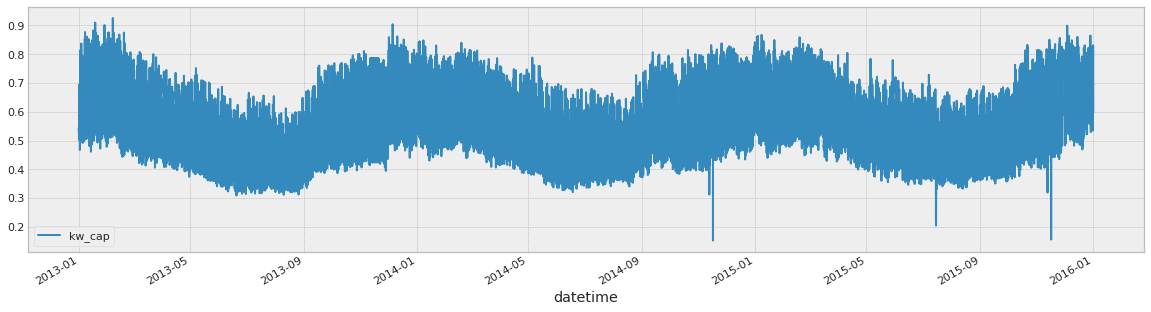

In [ ]:
import statsmodels.api as sm

data = df1.set_index('datetime')
data.plot(figsize=(20, 5))
plt.show()

In [ ]:
s1 = df1.kw_cap
type(s1)

pandas.core.series.Series

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

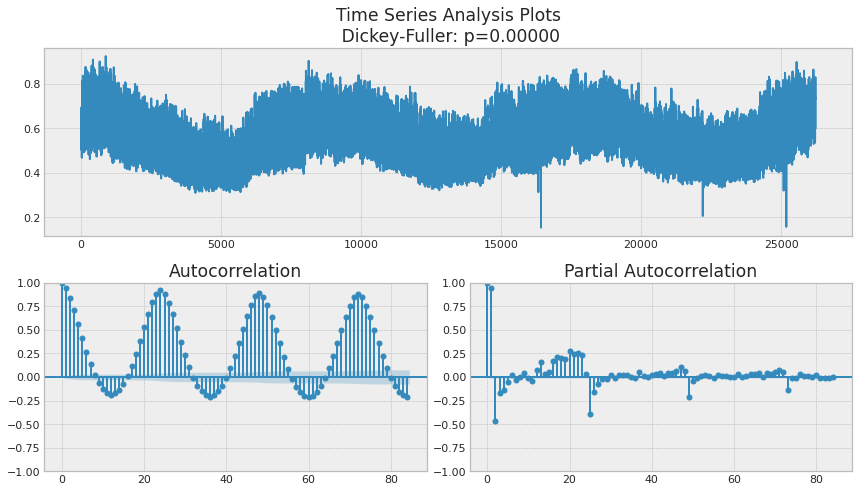

In [ ]:
tsplot(df1.kw_cap, lags=24*7*0.5)

## Split the data

In [ ]:
df2_agg=my_dict['df2'].groupby('date')['kw_cap'].sum().reset_index()
df2_agg=df2_agg.sort_values(by='date')
print(df2_agg.sample(2))
print()

s2_agg = df2_agg.kw_cap
print(len(s2_agg))

          date     kw_cap
748 2015-01-19  13.876541
633 2014-09-26  14.416667

1093


In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
test_agg_len = int(len(s2_agg)*0.2)
s2_agg_train, s2_agg_test = temporal_train_test_split(s2_agg, test_size=test_agg_len)

In [ ]:
len(s2_agg_test)

218

In [ ]:
# we have two days missing data
len(s1)-365*3*24

-48

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
test_len = int(len(s1)*0.2)
s1_train, s1_test = temporal_train_test_split(s1, test_size=test_len)
len(s1_test)

5246

## Define plot_forecast() function

In [ ]:
from IPython.core.pylabtools import figsize
def plot_forecast(series_train, series_test, forecast, forecast_int=None, extra_title="", train_label="train", test_label="test", 
                  figsize=(12, 4)):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=figsize)
    plt.title(extra_title + f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label=train_label, color="b")
    series_test.plot(label=test_label, color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape


## Define moving average

In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast."""
  mov = np.cumsum(series)
  # the past $window_size number of data points, the series has to be a Numpy array, 
  # which is quite different from Pandas Series
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

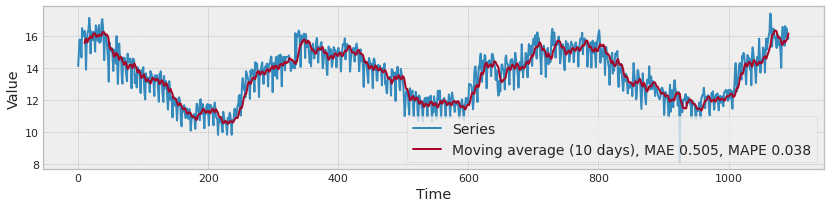

In [ ]:
window_size=10
moving_avg = moving_average_forecast(np.array(s2_agg), window_size)

mape = mean_absolute_percentage_error(moving_avg[-len(s2_agg_test):], s2_agg_test)
mae = mean_absolute_error(moving_avg[-len(s2_agg_test):], s2_agg_test)

plt.figure(figsize=(14, 3))
plot_series(range(len(s2_agg)), s2_agg, label="Series")
plot_series(range(window_size, len(s2_agg)), moving_avg, label=f"Moving average ({window_size} days), MAE {mae:.3f}, MAPE {mape:.3f}")

Text(0.5, 0.98, '')

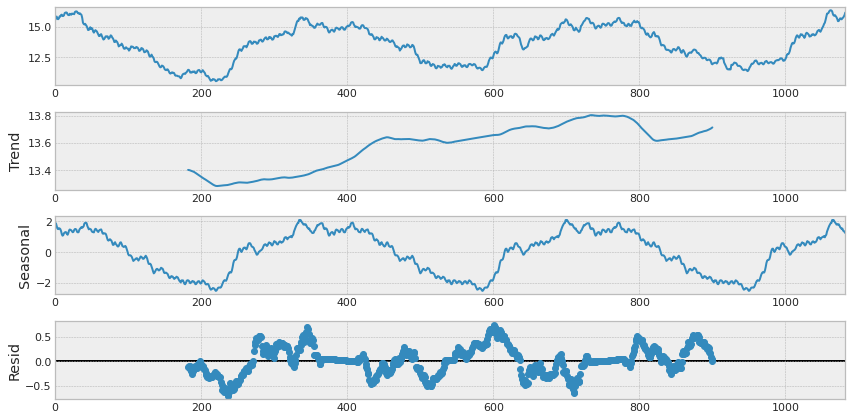

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
moving_avg = pd.Series(moving_avg)
decomp = seasonal_decompose(moving_avg, model='additive', period=365)
plt.rcParams.update({'figure.figsize':(12,6)})
decomp.plot().suptitle('')

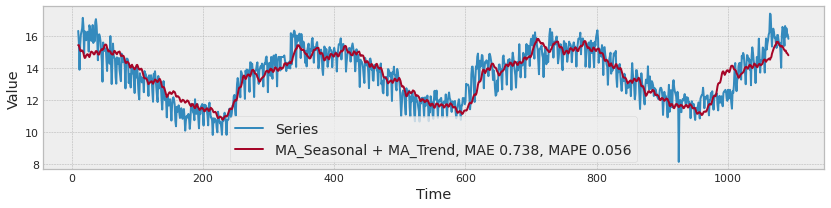

In [ ]:
s=decomp.seasonal+decomp.trend.fillna(decomp.trend.mean())

mape = mean_absolute_percentage_error(s[-len(s2_agg_test):], s2_agg_test)
mae = mean_absolute_error(s[-len(s2_agg_test):], s2_agg_test)

plt.figure(figsize=(14, 3))
plot_series(range(len(s2_agg)-len(s), len(s2_agg)), s2_agg[window_size:], label="Series")
plot_series(range(len(s2_agg)-len(s), len(s2_agg)), s, label=f"MA_Seasonal + MA_Trend, MAE {mae:.3f}, MAPE {mape:.3f}")

Moving Average of hourly data

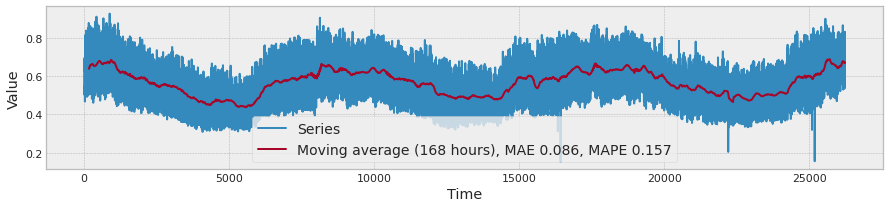

In [ ]:
window_size=24*7
moving_avg = moving_average_forecast(np.array(s1), window_size)

mape = mean_absolute_percentage_error(moving_avg[-len(s1_test):], s1_test)
mae = mean_absolute_error(moving_avg[-len(s1_test):], s1_test)

plt.figure(figsize=(15, 3))
plot_series(range(len(s1)), s1, label="Series")
plot_series(range(window_size, len(s1)), moving_avg, label=f"Moving average ({window_size} hours), MAE {mae:.3f}, MAPE {mape:.3f}")

##Forecast with `lgbregressor()`
- make_reduction(), During fitting, a sliding-window approach is used to first transform the time series into tabular or panel data, which is then used to fit a tabular or time-series regression estimator. During prediction, the last available data is used as input to the fitted regression estimator to generate forecasts. This is the process where we transform a time series into the `(X,y)` form. However, `window_length` in `make_reduction()` is only `len(X)`.
- `forecaster` is different from `regressor`. In forecasting, past data is used to make temporal forward predictions of a time series. This is notably different from tabular prediction tasks supported by scikit-learn and similar libraries.
- In fit, the composite algorithm uses a sliding window strategy to tabulate the data, and fit the regressor to the tabulated data. In predict, the composite algorithm presents the regressor with the last observed window to obtain predictions.

Check more [here](https://www.sktime.org/en/stable/examples/01_forecasting.html#3.-Advanced-composition-patterns---pipelines,-reduction,-autoML,-and-more)


In [ ]:
from sktime.transformations.series.detrend import Deseasonalizer

def create_forecaster_w_desesonalizer(regressor, model="additive", sp=365, degree=1, window_length=10, strategy="recursive", scitype='infer'):

    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model=model, sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
            #  window_length is going to be overwritten by param_grid search
                make_reduction(regressor, window_length=window_length, strategy=strategy, scitype=scitype),
            ),
        ]
    )

    return forecaster

In [ ]:
def regular_forecaster(train, test, forecaster, model_path=None, train_label="train", test_label="test"):

    forecaster.fit(train)

    if model_path:
      dump(forecaster, model_path) 
      # pickle.dump(forecaster, open(model_path, 'wb'))

    # forecasting, note the len(fh) must satisfy some requirements, here we have len(fh)= len(test)
    fh = np.arange(len(test)) + 1
    y_pred = forecaster.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred, train_label=train_label, test_label=test_label, figsize=(14, 4))

    return mae, mape

It turns that parameters given as `"forecast__window_length": 10, "deseasonalize__model":'additive', "detrend__forecaster__degree": 1` 
is better than our grid search, and naive forecasting.

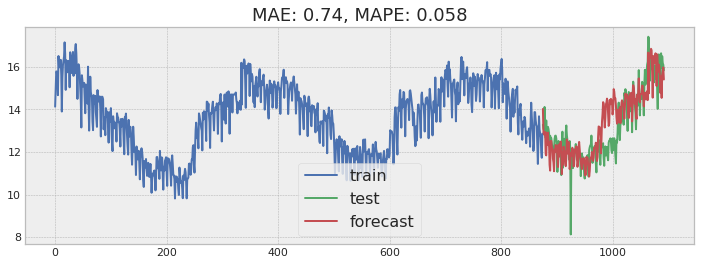

In [ ]:
regressor = lgb.LGBMRegressor(n_estimators=29, learning_rate=0.08)
forecaster = create_forecaster_w_desesonalizer(regressor,sp=365)

s2_agg_lgb_mae, s2_agg_lgb_mape = regular_forecaster(
    s2_agg_train, s2_agg_test, forecaster, model_path=model_root+"lgbm_forecaster.pickle"
)

**Hourly data**

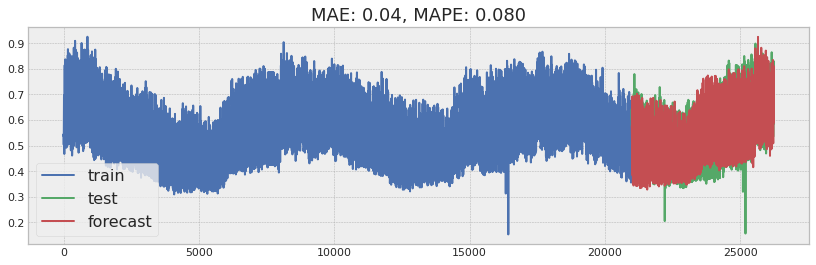

In [ ]:
regressor = lgb.LGBMRegressor(n_estimators=30, learning_rate=0.05)
forecaster = create_forecaster_w_desesonalizer(regressor,sp=365*24)

s1_lgb_mae, s1_lgb_mape = regular_forecaster(
    s1_train, s1_test, forecaster, model_path=None
)

In [ ]:
# forecaster.get_params()

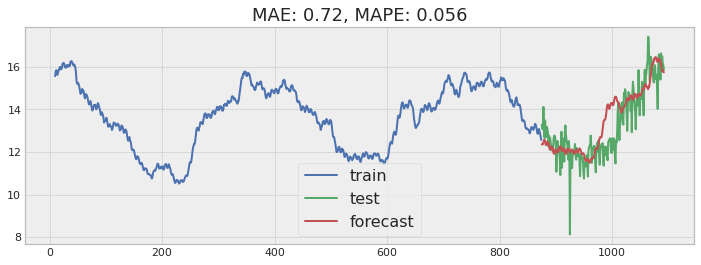

In [ ]:
window_size=10
ma = moving_average_forecast(np.array(s2_agg), window_size)
ma = pd.Series(ma, index=range(window_size,len(s2_agg)))
# ma_train should be very close to s2_agg_train, it has to satisfy this relation:
# (ma_train - s2_agg_train[10:]).sum()<<ma_train.sum()
ma_train = ma[:-len(s2_agg_test)]

regressor = lgb.LGBMRegressor(n_estimators=29, learning_rate=0.08)
forecaster = create_forecaster_w_desesonalizer(regressor,sp=365)

s2_agg_lgb_mae, s2_agg_lgb_mape = regular_forecaster(
    ma_train, s2_agg_test, forecaster, model_path=model_root+"lgbm_forecaster_MA.pickle"
)

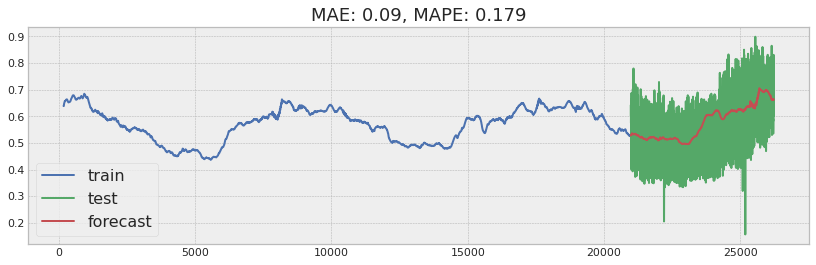

In [ ]:
window_size=24*7
ma = moving_average_forecast(np.array(s1), window_size)
ma = pd.Series(ma, index=range(window_size,len(s1)))
# ma_train should be very close to s1_train, it has to satisfy this relation:
# (ma_train - s1_train[window_size:]).sum()<<ma_train.sum()
ma_train = ma[:-len(s1_test)]

regressor = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05)
forecaster = create_forecaster_w_desesonalizer(regressor,sp=365*24)

_, _ = regular_forecaster(ma_train, s1_test, forecaster, model_path=None)

## `Linear` forecaster:
What if we just want to `deseasonalize` and `detrend` then get rid of the remainder?

In [ ]:
from sktime.transformations.series.detrend import Deseasonalizer
# deseasonalize and detrend the series
def create_transformer(y, model="additive", sp=365, degree=1):

    transformer = Deseasonalizer(model=model, sp=sp)
    y_hat = transformer.fit_transform(y)
    transformer = Detrender(forecaster=PolynomialTrendForecaster(degree=degree))
    y_hat = transformer.fit_transform(y_hat)

    return y_hat

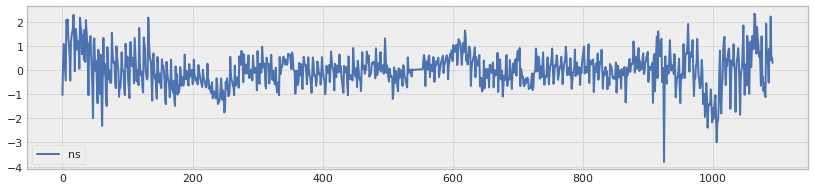

In [ ]:
ns=create_transformer(s2_agg, "additive", 370, 1)

plt.figure(figsize=(14, 3))
ns.plot(label='ns', color="b")
# s2_agg.plot(label='s2_agg', color="g")
plt.legend()
plt.show()

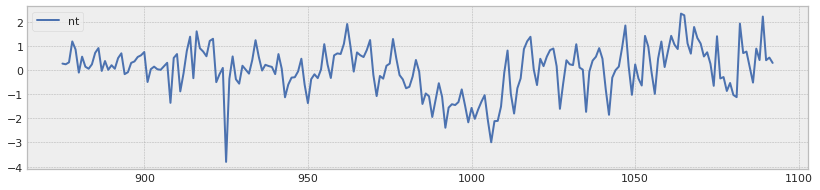

In [ ]:
nt=ns[len(s2_agg_train):]

plt.figure(figsize=(14, 3))
nt.plot(label='nt', color="b")
plt.legend()
plt.show()

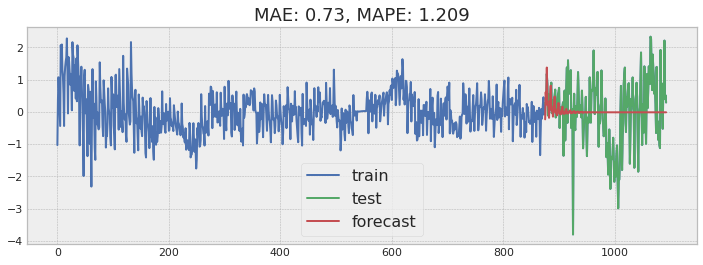

(0.7340492170272827, 1.2090778057022213)

In [ ]:
from sklearn.linear_model import LinearRegression
# We try to forecast the remainder after deseasonalization & detrending
regressor = LinearRegression()
forecaster = make_reduction(estimator=regressor, strategy='recursive', window_length=10)
regular_forecaster(ns, nt, forecaster)

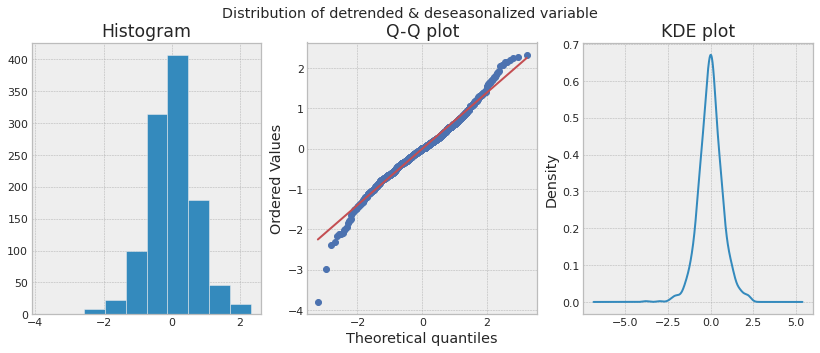

In [ ]:
# Note how the figsize actually adjusts all 3 plots as one overall plot
plt.subplots(figsize=(14,5))

#plot 1:
plt.subplot(1, 3, 1)
ns.hist()
plt.title("Histogram")

#plot 2:
plt.subplot(1, 3, 2)
from scipy.stats import probplot
probplot(x=ns,dist='norm',plot=plt)
plt.title("Q-Q plot")

#plot 3
plt.subplot(1,3,3)
ns.plot(kind="kde")
plt.title("KDE plot")

plt.suptitle("Distribution of detrended & deseasonalized variable")
plt.show()

- LinearRegression ater the data is deseasonalized & detrended gives the best result so far

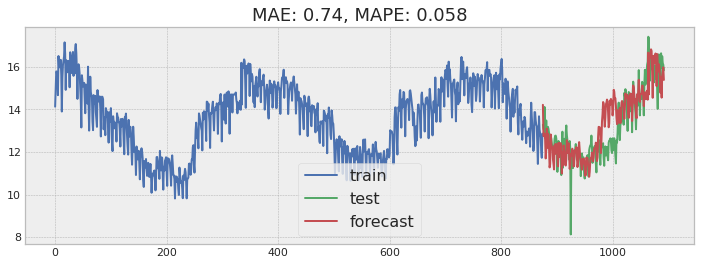

(0.7435496795815062, 0.05834271613938694)

In [ ]:
regressor = LinearRegression() # linearRegressor has scitype='tabular-regressor'

forecaster = create_forecaster_w_desesonalizer(regressor, sp=365, scitype='tabular-regressor')
# forecaster = make_reduction(estimator=regressor, strategy='recursive', window_length=10, scitype='tabular-regressor')
# forecaster = regressor

regular_forecaster(pd.Series(s2_agg_train), pd.Series(s2_agg_test), forecaster, model_path=model_root+"linear_forecaster.pickle")
# forecaster.fit(s2_agg_train)

**Hourly data**

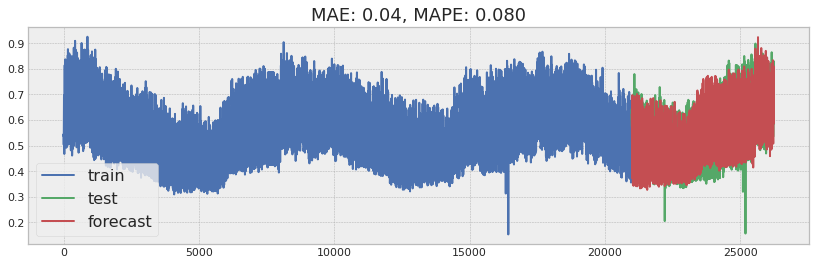

(0.04325164865042182, 0.07954045858455493)

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression() # linearRegressor has scitype='tabular-regressor'

forecaster = create_forecaster_w_desesonalizer(regressor, sp=365*24, scitype='tabular-regressor')

regular_forecaster(pd.Series(s1_train), pd.Series(s1_test), forecaster, model_path=None)

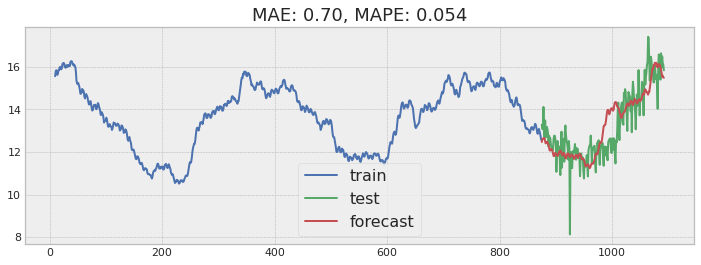

In [ ]:
window_size=10
ma = moving_average_forecast(np.array(s2_agg), window_size)
ma = pd.Series(ma, index=range(window_size,len(s2_agg)))
# ma_train should be very close to s2_agg_train, it has to satisfy this relation:
# (ma_train - s2_agg_train[10:]).sum()<<ma_train.sum()
ma_train = ma[:-len(s2_agg_test)]

regressor = LinearRegression() # linearRegressor has scitype='tabular-regressor'
forecaster = create_forecaster_w_desesonalizer(regressor, sp=365, scitype='tabular-regressor')

s2_agg_lgb_mae, s2_agg_lgb_mape = regular_forecaster(
    ma_train, s2_agg_test, forecaster, model_path=model_root+"linear_forecaster_MA.pickle"
)

**Hourly data**

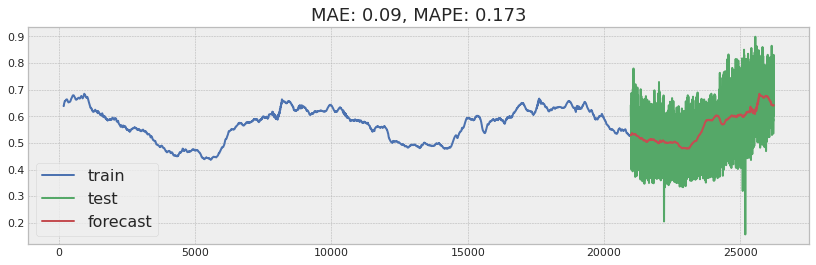

In [ ]:
window_size=24*7
ma = moving_average_forecast(np.array(s1), window_size)
ma = pd.Series(ma, index=range(window_size,len(s1)))
# ma_train should be very close to s1_train, it has to satisfy this relation:
# (ma_train - s1_train[window_size:]).sum()<<ma_train.sum()
ma_train = ma[:-len(s1_test)]

regressor = LinearRegression() # linearRegressor has scitype='tabular-regressor'
forecaster = create_forecaster_w_desesonalizer(regressor, sp=365*24, scitype='tabular-regressor')

_, _ = regular_forecaster(
    ma_train, s1_test, forecaster, model_path=None
)

### LinearRegression with DirectTabularRegressionForecaster()

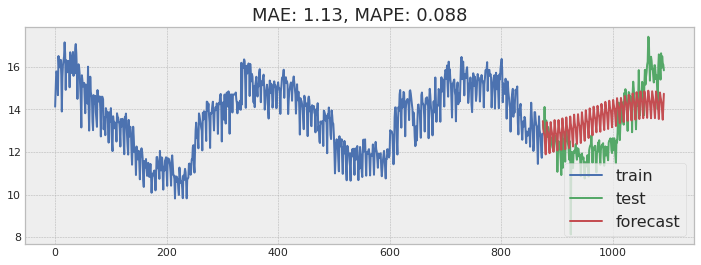

(1.1276687311294529, 0.08777619927282612)

In [ ]:
from sktime.forecasting.compose import DirectTabularRegressionForecaster
from sktime.utils.plotting import plot_series

forecaster = DirectTabularRegressionForecaster(LinearRegression())
forecaster.fit(s2_agg_train, fh=np.arange(test_agg_len) + 1)
y_pred = forecaster.predict()

plot_forecast(s2_agg_train, s2_agg_test, y_pred)